In [1]:
#TODO - remove filter magic number sizes, replace with scalar multiple of two in __init__
#TODO - add reference batches feature args to batch_norm in here and in ops.py
#TODO - go through magic numbers, and there are a few, and put them in flags. see top of train()
#TODO - write other

import tensorflow as tf
import flags
import ops
import data_utils
import numpy as np
from tensorflow.contrib.layers import l2_regularizer, fully_connected, flatten, batch_norm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 

class DeepConvGenAdvNet():
    
    def __init__(self, image_shape, z_size, dtype=tf.float32):
        self.sess = None
        self.image_shape = image_shape # a list
        self.dtype = dtype
        self.z_size = z_size
        self.reference_batch_mean = None
        self.reference_batch_var = None
    
    #Discriminators in DCGAN's don't often use pooling layers, but instead strided convolutions to learn downsampling
    #They rely heavily on batch normalization and different activations functions like a leaky relu
    #No batch norm is used on the discriminator input layer so that the model can learn a proper scale
    def discriminator(self,
                     X,
                     reuse=True,
                     init_depth=64,
                     batch_norm_momentum=0.9,
                     dropout_keep_prob=0.5,
                     training=True):
        
        assert X.get_shape().as_list()[1:] == list(self.image_shape), "Discriminator input shape (%s), ignoring batch_size, is different than expected shape %s" % (X.get_shape().as_list()[1:] , list(self.image_shape))
        assert X.dtype == self.dtype, "Unmatching datatypes"
        
        with tf.variable_scope("Discriminator", reuse=reuse):
            
            #Layer 1 is a 5x5 conv with stride 1, which turns our 32x32x3 into 16x16x64
            h1 = ops.conv(X,
                         init_depth,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="d_l1_conv")
            h1_a = ops.leaky_relu(h1, alpha=0.2)
            
            #if training:
            #    h1_dropped = tf.nn.dropout(h1_a, dropout_keep_prob, name="d_l1_dropout")
            #else:
            #    h1_dropped = h1_a
            
            #Layer 2 is a 5x5 conv with stride 2, which turns our 16x16x64 into 8x8x128.
            # We then apply a batch normalization to this
            h2 = ops.conv(h1_a,
                         init_depth*2,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="d_l2_conv")
            
            h2_bn = batch_norm(h2,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="d_l2_bn")
            h2_a = ops.leaky_relu(h2_bn, alpha=0.2)

            #if training:
            #    h2_dropped = tf.nn.dropout(h2_a, dropout_keep_prob, name="d_l2_dropout")
            #else:
            #    h2_dropped = h2_a

            #Layer 3 is a 5x5 conv with stride 2, which turns out 8x8x128 into a 4x4x256
            # Then another batch norm
            h3 = ops.conv(h2_a,
                         init_depth*4,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="d_l3_conv")
            
            h3_bn = batch_norm(h3,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="d_l3_bn")
            
            h3_a = ops.leaky_relu(h3_bn, alpha=0.2)
            
            #if training:
            #    h3_dropped = tf.nn.dropout(h3_a, dropout_keep_prob, name="d_l3_dropout")
            #else:
            #    h3_dropped = h3_a
            
            #Layer 4 is a 5x5 conv with stride 2, which turns out 4x4x256 into a 2x2x512
            # Then another batch norm
            h4 = ops.conv(h3_a,
                         init_depth*8,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="d_l4_conv")
            
            h4_bn = batch_norm(h4,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="d_l4_bn")
            
            h4_a = ops.leaky_relu(h4_bn, alpha=0.2)
            
            #if training:
            #    h4_dropped = tf.nn.dropout(h4_a, dropout_keep_prob, name="d_l4_dropout")
            #else:
            #    h4_dropped = h4_a
            
            #flatten and pass to a dense layer
            h5_flat = flatten(h4_a)
            h5_dense = fully_connected(h5_flat,
                                        1, #A single output
                                        activation_fn=None, #sigmoid later...easier access to investigating these latent vars
                                        weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                        weights_regularizer=None,
                                        biases_initializer=tf.zeros_initializer(),
                                        biases_regularizer=None)
            
            #we can finally run our sigmoid to get a [0,1] probability
            return tf.sigmoid(h5_dense), h5_dense
            
    def generator(self,
                  z,
                  sample_size=1,
                  max_depth=512,
                  batch_norm_momentum=0.9,
                  dropout_keep_prob=0.5,
                  training=True):
        
        with tf.variable_scope("Generator"):
            
            #Output height and widths based on image size
            l5_h, l5_w = self.image_shape[0], self.image_shape[1]
            l4_h, l4_w = ops.conv_out_size(l5_h, 1), ops.conv_out_size(l5_w, 1)
            l3_h, l3_w = ops.conv_out_size(l4_h, 2), ops.conv_out_size(l4_w, 2)
            l2_h, l2_w = ops.conv_out_size(l3_h, 2), ops.conv_out_size(l3_w, 2)
            l1_h, l1_w = ops.conv_out_size(l2_h, 2), ops.conv_out_size(l2_w, 2)
            
            #Output depths based on image size in our fractionally-strided convolutions
            l1_d = max_depth
            l2_d = l1_d / 2
            l3_d = l2_d / 2
            l4_d = l3_d / 2
            l5_d = self.image_shape[2]
            
            #we know our output size needs to be that of the image. 
            fc_out_size = l1_h * l1_w * l1_d
            
            #Layer 1 builds a dense projection size that can be flattened to the right 4d size.
            # This also uses batch norm and a leaky relu.
            h1 = fully_connected(z,
                                fc_out_size,
                                activation_fn=None, #sigmoid later...easier access to investigating these latent vars
                                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                weights_regularizer=None,
                                biases_initializer=tf.zeros_initializer(),
                                biases_regularizer=None)
                        
            h1_bn = batch_norm(h1,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="g_l1_bn")
            
            h1_a = tf.nn.relu(h1_bn)
            
            #Reshape. For cifar10 this will make 4x4x512
            h1_reshape = tf.reshape(h1_a, [-1, l1_h, l1_w, l1_d ] )
            
            #Layer 2 is a convolutional transpose on the reshaped data. This gets us to 8x8x256
            h2 = ops.conv_transpose(h1_reshape,
                                   [sample_size, l2_h, l2_w, l2_d],
                                   strides=[2,2],
                                   w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                   regularizer=None,
                                   name="g_l2_conv_t")
            
            h2_bn = batch_norm(h2,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="g_l2_bn")
            
            #h2_a = ops.leaky_relu(h2_bn, alpha=0.2)
            h2_a = tf.nn.relu(h2_bn)
            
            #Layer 3 brings us to 16 x 16 x 128, and is just like layer 2
            h3 = ops.conv_transpose(h2_a,
                                   [sample_size, l3_h, l3_w, l3_d],
                                    strides=[2,2],
                                   w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                   regularizer=None,
                                   name="g_l3_conv_t")
            
            h3_bn = batch_norm(h3,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="g_l3_bn")
            
            h3_a = tf.nn.relu(h3_bn)
            
            #Layer 4 brings us to 32 x 32 x 64, and is just like layer 2
            h4 = ops.conv_transpose(h3_a,
                                   [sample_size, l4_h, l4_w, l4_d],
                                   strides=[2,2],
                                   w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                   regularizer=None,
                                   name="g_l4_conv_t")            
            h4_bn = batch_norm(h4,
                               decay=batch_norm_momentum,
                               updates_collections=None,
                               epsilon=1e-5,
                               scale=True,
                               is_training=training,
                               scope="g_l4_bn")
            h4_a = tf.nn.relu(h4_bn)
            
            #Layer 5 is like layers 2 and 3, but it instead uses sigmoid activation, and outputs the number
            # of outputs channels in the final generated image
            h5 = ops.conv_transpose(h4_a,
                                   [sample_size, l5_h, l5_w, l5_d], #probably 1 (mnist) or 3 (cifar10, cifar100, imagenet)
                                   strides=[1,1],
                                   w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                   regularizer=None,
                                   name="g_l5_conv_t")
            #return tf.nn.tanh(h5)
            return tf.sigmoid(h5), h5

    def train(self, train_X, batch_size, epochs):
        
        #TODO - migrate these elsewhere
        d_lr_init = 0.0001
        g_lr_init = 0.0002
        d_lr_steps = 1000
        g_lr_steps = 1000
        d_lr_decay = 1.0
        g_lr_decay = 1.0
        d_lr_min = 0.00001
        g_lr_min = 0.00001
        d_momentum = 0.1
        g_momentum = 0.3
        d_min_grad = -1.0
        g_min_grad = -1.0
        d_max_grad = 1.0
        g_max_grad = 1.0

        reg_loss_lambda = 0.001
        
        d_global_step = tf.Variable(0, trainable=False)
        g_global_step = tf.Variable(0, trainable=False)

        #Create placeholder inputs for images, and separate the discriminator loss terms so that
        # we can investigate them separately
        assert list(train_X.shape[1:]) == list(self.image_shape), "Training set image size does not match expected class image size"
        
        X_tr = tf.placeholder(self.dtype, shape=[batch_size] + list(self.image_shape) )
        z = tf.placeholder(self.dtype, shape=[batch_size, self.z_size])
        
        #We can define the generated images, as well as the discriminator network passes through both the real images and fakeones
        g, g_logits = self.generator(z, sample_size=batch_size)
        d_real, d_real_logits = self.discriminator(X_tr, reuse=False)
        d_fake, d_fake_logits = self.discriminator(g, reuse=True)

        #Define the loss function by pure binary cross entropy
        d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real)))
        d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake)))
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake)))
        d_loss = d_real_loss + d_fake_loss
        
        #Define separate learning rates for the generator and discrimninator (put these in flags)
        d_lr = tf.maximum(d_lr_min, tf.train.exponential_decay(d_lr_init, d_global_step, d_lr_steps, d_lr_decay, staircase=True))
        g_lr = tf.maximum(g_lr_min, tf.train.exponential_decay(g_lr_init, g_global_step, g_lr_steps, g_lr_decay, staircase=True))
 
        #TODO - get regularization losses here
        #reg_loss = tf.GraphKeys.REGULARIZATION_LOSSES * reg_loss_lambda_flag
        
        #We must capture the trained variables for the discriminator and generator and isolate them
        # so that we can oscillate back and forth in training between which one is having their gradients updated.
        discriminator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Discriminator')
        generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Generator')

        #Use these learning rates in defined Adam Optimizer
        d_opt = tf.train.AdamOptimizer(learning_rate=d_lr, beta1=d_momentum)
        g_opt = tf.train.AdamOptimizer(learning_rate=g_lr, beta1=g_momentum)
        
        #Split the vall to minimize into compute and apply gradients, so that we can clip large gradients
        d_grads = d_opt.compute_gradients(d_loss, var_list=discriminator_vars)
        g_grads = g_opt.compute_gradients(g_loss, var_list=generator_vars)
        
        #clip them and apply them
        d_grads_clipped = [(tf.clip_by_value(g, d_min_grad, d_max_grad), v) for g, v in d_grads]
        g_grads_clipped = [(tf.clip_by_value(g, g_min_grad, g_max_grad), v) for g, v in g_grads]
        d_train_op = d_opt.apply_gradients(d_grads_clipped, global_step=d_global_step)
        g_train_op = g_opt.apply_gradients(g_grads_clipped, global_step=g_global_step)

        with tf.Session() as sess:
            
            self.sess = sess
            report_frequency = 100 #steps
            sess.run(tf.global_variables_initializer())
            
            print("Initialized session variables")

            iterations = int(train_X.shape[0] / batch_size)
            
            epoch_d_losses = []
            epoch_g_losses = []
            
            for epoch in range(epochs):
                
                #shuffle data per epoch
                print("Epoch %d / %d now training..." % (epoch+1, epochs))
                d_losses = []
                g_losses = []
                shuf = np.random.permutation(train_X.shape[0])
                train_X = train_X[shuf]

                for i in range(iterations):
                    
                    #next batch, TODO - remove overflow protection here
                    try:
                        x = train_X[ i*batch_size:(i+1)*batch_size, :, :, :]
                    except IndexError:
                        break
                    noise = np.random.uniform(0., 1., size=[batch_size, self.z_size])
                    
                    #first run the discriminator, and only train its vars
                    dt, df, _, d_loss_val = sess.run([d_real, d_fake, d_train_op, d_loss], {X_tr: x, z:noise})
                    
                    #then run the generator, and only train its vars
                    noise2 = np.random.uniform(0., 1., size=[batch_size, self.z_size])
                    _, g_loss_val = sess.run([g_train_op, g_loss], {z:noise2})
                    
                    d_losses.append(d_loss_val)
                    g_losses.append(g_loss_val)
                    
                    if i % report_frequency == 0:
                        print("Epoch step %d - D-Loss: %f\t G-Loss:%f") % (i+1, d_loss_val, g_loss_val)
                
                print("Epoch %d - Avg: D-Loss: %f\t Avg: G-Loss:%f") % (i+1, np.mean(d_losses), np.mean(g_loss_val))
                epoch_d_losses.append(np.mean(d_losses))
                epoch_g_losses.append(np.mean(g_losses))
                
                print("Generated sample images:")
                _, gen_logits = sess.run([g, g_logits], {z: noise2})
                self.show_samples(gen_logits)
            
            self.show_losses(epoch_d_losses, epoch_g_losses)

    def show_samples(self, samples, n=25):
        
        sq_s = np.sqrt(n)
        assert samples.shape[0] >= n, "Num samples (%d) is larger than the number of samples passed to show_samples (%d)" % (n, samples.shape[0])
        assert round(sq_s)==sq_s, "Expected to show samples in an nxn grid. Pass a perfect square less than the sample size as n"
        sq_s = int(sq_s)
        
        gs = gridspec.GridSpec(sq_s, 2*sq_s)
        gs.update(wspace=0.05, hspace=0.05)
        
        for idx, sample in enumerate(samples):
            if idx > n-1:
                break
            ax = plt.subplot(gs[(idx % sq_s), int(idx / sq_s)])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(np.squeeze(sample), cmap='Greys_r')
        plt.show()
        
    def show_losses(self, d_losses, g_losses):
        pass
    
    def collections_report(self):
        print("The following variables are trained by the discriminator:")
        for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Discriminator'):
            print("\t%s"%var.name)
        print("The following variables are trained by the generator:")
        for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Generator'):
            print("\t%s"%var.name)    
        
    #See Generative Adversarial Networks NIPS 2016 Tutorial, page 33
    #None, flesh out. Assign to batch norm in ops to avoid calculation if these are set args
    def assign_reference_batch(self):
        self.reference_batch_mean = None
        self.reference_batch_var = None
        

In [2]:
#Load the Dataset
FLAGS = tf.app.flags.FLAGS
batch_size = FLAGS.batch_size

(train_X, train_y), (_,_) = data_utils.load_dataset(FLAGS.dataset)
shuf = np.random.permutation(train_X.shape[0])
train_X = train_X[shuf]
train_y = train_y[shuf]

In [ ]:
my_GAN = DeepConvGenAdvNet( train_X.shape[1:], 100)

Initialized session variables
Epoch 1 / 50 now training...
Epoch step 1 - D-Loss: 1.583970	 G-Loss:2.911636
Epoch step 101 - D-Loss: 1.456073	 G-Loss:0.776008
Epoch step 201 - D-Loss: 1.242589	 G-Loss:0.826320
Epoch step 301 - D-Loss: 1.320938	 G-Loss:1.088042
Epoch 390 - Avg: D-Loss: 1.317366	 Avg: G-Loss:1.261778
Generated sample images:


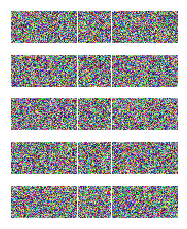

Epoch 2 / 50 now training...
Epoch step 1 - D-Loss: 1.306660	 G-Loss:0.788334
Epoch step 101 - D-Loss: 1.193810	 G-Loss:1.485035
Epoch step 201 - D-Loss: 1.330754	 G-Loss:1.134728
Epoch step 301 - D-Loss: 1.457254	 G-Loss:0.927142
Epoch 390 - Avg: D-Loss: 1.341316	 Avg: G-Loss:0.727192
Generated sample images:


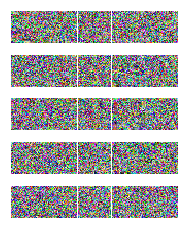

Epoch 3 / 50 now training...
Epoch step 1 - D-Loss: 1.342963	 G-Loss:0.836204
Epoch step 101 - D-Loss: 1.383122	 G-Loss:0.874532
Epoch step 201 - D-Loss: 1.370033	 G-Loss:0.832306
Epoch step 301 - D-Loss: 1.406888	 G-Loss:0.860507
Epoch 390 - Avg: D-Loss: 1.371328	 Avg: G-Loss:0.860072
Generated sample images:


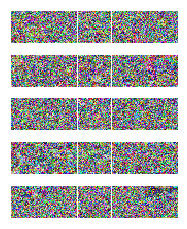

Epoch 4 / 50 now training...
Epoch step 1 - D-Loss: 1.379447	 G-Loss:0.841444


In [ ]:
my_GAN.train(train_X, batch_size, 50)